(multilevel_hgf)=
# Embeding the HGF in a multilevel model

In [1]:
from numpy import loadtxt
from ghgf.distribution import hgf_logp, HGFDistribution
from ghgf import load_data
import jax.numpy as jnp
import numpy as np
import pymc as pm
import arviz as az

In this tutorial, we are going to estimate the group-level probability density distribution of HGF parameters.

## Using the automated broadcasting for models creation
Estimating group-level parameters in the context of a graphical probabilistic model require to fit multiple models at the same time, either on different input data, or on the same data with different parameters, or on different datasets with different parameters. This steps is handled natively both by the `:py:class:ghgf.distribution.hgf_logp` class and the `:py:class:ghgf.distribution.HGFDistribution` class through automated [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html).

In [5]:
# Create an example dataset using inverted copies of the original time series
timeserie = load_data("continuous")

data = [timeserie[i*100:i*100+100] for i in range(6)]

In [7]:
hgf_logp(
    omega_1 = -3.0,
    omega_2 = -3.0,
    omega_input = jnp.log(1e-4),
    rho_1 = 0.0,
    rho_2 = 0.0,
    pi_1 = 1e4,
    pi_2 = 1e1,
    mu_1 = 1.0,
    mu_2 = 0.0,
    kappa_1 = 1.0,
    bias = 0.0,
    input_data = data,
    model_type = "continuous",
    n_levels = 2,
    response_function = None
)

DeviceArray(1934.7451, dtype=float32)

## Embedding a serie of HGFs in a graphical model

Here, we are goingin to estimate the group-level value of the `omega_1` parameter. The dataset consist in 3 time series derived from the classic USD-SWF conversion rate example. Every time series will be fitted to an HGF model where the `omega_1` parameter has to be estimated and the other parameters are fixed.

In [9]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    input_data=data,
)

In [10]:
with pm.Model() as model:
    
    # Hypterpriors
    #-------------
    #mu_omega_2 = pm.Normal("mu_omega_2", -2.0, 5.0)
    #sigma_omega_2 = 2.0 # pm.Uniform("sigma_omega_2", 0, 10.0)
    
    # Priors
    #-------
    normal_dist2 = pm.Normal.dist(mu=-2.0, sigma=2.0, shape=6)
    omega_2 = pm.Censored("omega_2", normal_dist2, lower=-20.0, upper=2)
    mu_1 = pm.Uniform("mu_1", 0, 2, shape=6)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=-2.0,
            omega_2=omega_2,
            omega_input=np.log(1e-4),
            rho_1=0.0,
            rho_2=0.0,
            pi_1=1e4,
            pi_2=1e1,
            mu_1=mu_1,
            mu_2=0.0,
            kappa_1=1.0,
            bias=0.0,
        ),
    )

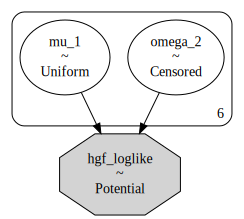

In [11]:
pm.model_to_graphviz(model)

In [12]:
with model:
    idata = pm.sample(chains=4, cores=4, tune=1000)

/opt/anaconda3/lib/python3.8/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


array([[<AxesSubplot: title={'center': 'omega_2'}>,
        <AxesSubplot: title={'center': 'omega_2'}>],
       [<AxesSubplot: title={'center': 'mu_1'}>,
        <AxesSubplot: title={'center': 'mu_1'}>]], dtype=object)

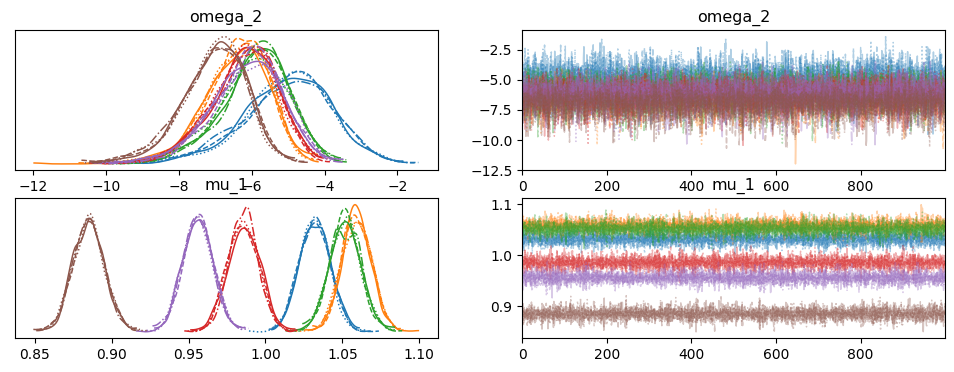

In [13]:
az.plot_trace(idata)